Step One is to create a data set, as we saw in earlier videos. If you took my example and modified it, add a comment explaining what your modification was.

In [1]:
import datetime
import math
import random
import pandas as pd
import numpy as np
now = datetime.datetime.now()
nfolds = 5
SEED = 123
random.seed(SEED)

In [2]:
N = 1000

In [3]:
bloodTypes = ['A','A','A','O','O','O','AB','B']

In [4]:
d = pd.DataFrame(list(range(1, N+1)), columns=['id'])

In [5]:
d['bloodTypes']=[bloodTypes[(i%len(bloodTypes))] for i in range(1, N+1)]

In [6]:
from numpy.random import randint
d['age'] = randint(18, 65, N)

In [7]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [8]:
X = get_truncated_normal(mean=5, sd=2, low=0, upp=9)

In [9]:
d['healthyEating'] = X.rvs(N)
d['healthyEating'] = round(d['healthyEating'])

In [10]:
d['activeLifestyle'] = np.where(d['age']<30, 1, 0)
d['activeLifestyle'] = X.rvs(N)+d['activeLifestyle']
d['activeLifestyle'] = round(d['activeLifestyle'])
d['activeLifestyle'] = d['activeLifestyle'].clip(upper=9)

In [11]:
d['income'] = 20000 + (d['age']*3)**2
d['income'] = d['income'] + d['healthyEating']*500
d['income'] = d['income'] - d['activeLifestyle']*300
d['income'] = d['income'] + randint(0, 5000, N)
d['income'] = round(d['income'] / 100) * 100

Step Two is to start h2o, and import your data.

In [12]:
d.describe()

,id,age,healthyEating,activeLifestyle,income
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,41.224000,4.865000,5.196000,40267.700000
std,288.819436,13.235445,1.862859,1.948173,10124.145645
min,1.000000,18.000000,0.000000,0.000000,23500.000000
25%,250.750000,30.000000,3.000000,4.000000,31800.000000
50%,500.500000,41.000000,5.000000,5.000000,38600.000000
75%,750.250000,52.000000,6.000000,7.000000,48300.000000
max,1000.000000,64.000000,9.000000,9.000000,63800.000000


In [13]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_102"; Java(TM) SE Runtime Environment (build 1.8.0_102-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.102-b14, mixed mode)
  Starting server from /Users/tim.wu/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/61/sfyb5b517dd3tj1_cdjsx6_w0000gn/T/tmpefkqc_j0
  JVM stdout: /var/folders/61/sfyb5b517dd3tj1_cdjsx6_w0000gn/T/tmpefkqc_j0/h2o_tim_wu_started_from_python.out
  JVM stderr: /var/folders/61/sfyb5b517dd3tj1_cdjsx6_w0000gn/T/tmpefkqc_j0/h2o_tim_wu_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,1 month and 24 days
H2O cluster name:,H2O_from_python_tim_wu_3h5qh6
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [14]:
people = h2o.H2OFrame(d, destination_frame = "people")

Parse progress: |█████████████████████████████████████████████████████████| 100%


Step Three is to split the data. If you plan to use cross-validation, split into train and test. Otherwise split into train, valid and test

In [15]:
train, valid, test = people.split_frame(ratios = [0.8, 0.1], destination_frames = ["train", "valid", "test"], seed=SEED)

Step four is to choose either random forest or gbm, and make a model. It can be classification or regression. Then show the results, on both training data and the test data. You can show all the performance stats, or choose just one (e.g. I focused on MAE in the videos).

In [16]:
# Identify predictors and response
x = people.columns
y = "income"
x.remove(y)

In [17]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [18]:
mGBM_default = H2OGradientBoostingEstimator(model_id = "GBM_model_default_"+now.strftime("%Y-%m-%d_%H_%M_%S"),
                                   ntrees = 15,
                                   nfolds = nfolds,
                                   fold_assignment = "Modulo",
                                   keep_cross_validation_predictions = True,
                                   seed = SEED)
%time mGBM_default.train(x, y, train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 34.6 ms, sys: 12.7 ms, total: 47.2 ms
Wall time: 753 ms


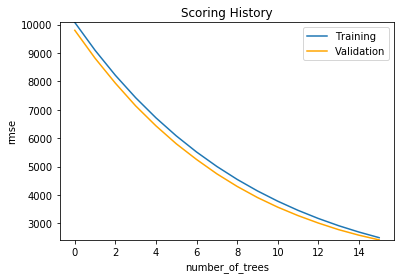

In [19]:
mGBM_default.plot()

In [20]:
print("GBM Default Train MAE score: %f" % mGBM_default.mae(train=True))
print("GBM Default Validation MAE score: %f" % mGBM_default.mae(valid=True))
print("GBM Default Cross Validation MAE score: %f" % mGBM_default.mae(xval=True))
perf = mGBM_default.model_performance(test)
print("GBM Default Test MAE score: %f" % perf.mae())

GBM Default Train MAE score: 2055.176450
GBM Default Validation MAE score: 1962.151933
GBM Default Cross Validation MAE score: 2170.123234
GBM Default Test MAE score: 2278.302876


Step five is then to try some alternative parameters, to build a different model, and show how the results differ.

In [21]:
mGBM_overfit = H2OGradientBoostingEstimator(model_id = "GBM_model_python_"+now.strftime("%Y-%m-%d_%H_%M_%S"),
                                   ntrees = 500,
                                   max_depth =10,
                                   nfolds = nfolds,
                                   fold_assignment = "Modulo",
                                   keep_cross_validation_predictions = True,
                                   seed = SEED)
%time mGBM_overfit.train(x, y, train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 234 ms, sys: 122 ms, total: 357 ms
Wall time: 8.56 s


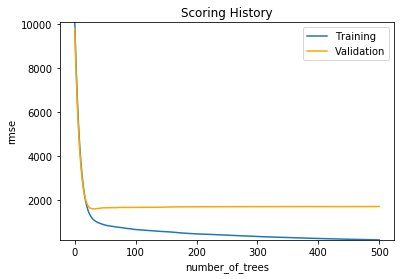

In [22]:
mGBM_overfit.plot()

In [23]:
print("GBM Overfit Train MAE score: %f" % mGBM_overfit.mae(train=True))
print("GBM Overfit Validation MAE score: %f" % mGBM_overfit.mae(valid=True))
print("GBM Overfit Cross Validation MAE score: %f" % mGBM_overfit.mae(xval=True))
perf = mGBM_overfit.model_performance(test)
print("GBM Overfit Test MAE score: %f" % perf.mae())

GBM Overfit Train MAE score: 153.346722
GBM Overfit Validation MAE score: 1455.279747
GBM Overfit Cross Validation MAE score: 1501.757646
GBM Overfit Test MAE score: 1397.007384


Step six is to save your script, then close down h2o, and run your script in a fresh session to make sure there are no bugs and the results are repeatable. If your script takes more than a couple of minutes to run, please put the required resources in a comment at the very top. (But first consider if you can get the same results with a smaller data set: this task is about tuning and over-fitting, not about big data.)

In [24]:
h2o.cluster().shutdown()

H2O session _sid_a1d5 closed.
